# Подготовка данных
Все пункты в первом разделе необходимо запустить для настройки и создания необходимых процедур. Разделы содержат пояснения по данным

## Подключения и настройки

### Подключения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy import stats
%matplotlib inline
import statistics
import seaborn as sns
import locale
import gc

### Настройки

In [2]:
pd.options.display.float_format ='{:.2f}'.format
pd.plotting.register_matplotlib_converters()
locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8');
pd.options.display.max_columns = None

### Дополнительные процедуры

#### Truedescribe
Получает на вход dataframe и описывает его чуть более понятно, чем describe.

Дополняет описание гистрограммами распределения, общим описанием, типами данных колонок, суммой, выборкой первых и последних vals сортированных значений колонки, а также vals случайных строк.

In [3]:
def truedescribe (dftd, vals=3):
    dftd=dftd.copy()
    dfcolumns=dftd.columns
    l=1
# строим гистограммы распределения всех столбцов, кроме текстовых и временной разницы
    headers=dftd.select_dtypes(exclude=['object', 'timedelta64']).columns
    for i in headers:
        l+=1
        plt.subplot(1, len(headers)+1, l)
        if (dftd[i].dtypes=='bool'):
            dftd[i].astype(int).hist(figsize=(20,4), label=i)
        else:
            dftd[i].hist(figsize=(20,4), label=i)
        plt.title(i)
# выводим общие характеристики датафрейма
    print('{:n} rows X '.format(len(dftd)),len(dfcolumns),'columns X {:n}'.format(dftd.size), 'items X {:n}'.format(sum(dftd.count())),'nonnull items X {:n}'.format(dftd.memory_usage(deep=True).sum()/1024),' Kbytes')
# выводим количество колонок разных типов
    print(dftd.dtypes.value_counts().to_string())
# берём стандартную функцию описания столбцов датафрейма, чтобы выбрать/заменить/дополнить параметры
    dscb=dftd.describe(include='all', datetime_is_numeric=True)
# доля непустых значений в столбце
    dscb.loc['nonnull%']=dftd.agg("count")/len(dftd)*100
# тип данных в столбце
    dscb.loc['dtype']=dftd.dtypes
# сумма в столбце
    dscb.loc['sum']=dftd.sum(numeric_only=True)
# медиана в столбце
    dscb.loc['median']=dftd.median(numeric_only=True)
# меняем порядок характеристик столбцов и отбираем их
    dscb = dscb.reindex(index = ['dtype','nonnull%','count', 'unique', 'mean', 'median', 'top', 'freq', 'sum'])
    dftd1  = pd.DataFrame()
    dftd2  = pd.DataFrame()
# по каждому столбцу добавляем
    for col in dfcolumns:
# первые vals отсортированных по порядку значений без пустых ячеек (первое эквивалентно минимальному)
        dftd1[col]=dftd[col].sort_values(ignore_index=True,ascending=True,na_position='last').head(vals)
# последние vals отсортированных по порядку значений без пустых ячеек (последнее эквивалентно максимальному)
        dftd2[col]=dftd[col].sort_values(ignore_index=True,ascending=True,na_position='first').tail(vals)
# заменяем стандартное колничество уникальных значений, которое плохо тем, что не рассчитывается для чисел
        dscb.loc['unique', col]=dftd[col].nunique()
        if (dscb.loc['dtype', col]=='datetime64[ns]'): 
            dscb.loc['median', col]=dftd[col].quantile(0.5, interpolation="midpoint")
        if (dscb.loc['dtype', col]=='timedelta64[ns]'): 
            dscb.loc['median', col]=dftd[col].quantile(0.5, interpolation="midpoint")
    dscb=[dscb,dftd1.set_index('asc_'+dftd1.index.astype(str)),dftd2.set_index('asc_'+dftd2.index.astype(str)).sort_index(ascending=False)]
# добавляем vals случайных строк из датасета
    for i in range(vals):
        t=dftd.sample()
        dscb.append(t.set_index('rnd_'+t.index.astype(str)))
    dscb=pd.concat(dscb)
    del dftd
    return dscb

## load_ &nbsp;&nbsp;&nbsp; | &nbsp;&nbsp;&nbsp; Загрузка CSV
Функции, загружающие csv - только приводят данные к нужным типам. Перед каждой функцией даю описание-выводы о таблице на основе характеристик данных.
### crm_data
**Список заказов** с датой создания строго в третьем квартале 2020 года. При этом даты оплаты, изменения и отмены встречаются до середины 2021 года. То есть, данные взяты по состоянию не ранее, чем через полгода после создания последнего заказа, следовательно:
1. при среднем времени до оплаты или отмены заказа равном 5 дней **статусы всех заказов следует считать финальными**
2. **данные об оплатах, изменениях и отменах заказов в третьем квартале по более ранним заказам следует считать существущими, но отсутствующими в этой таблице.**

Заказы в статусе StatusZakaza "Возврат заказа: ожидает отправки" без даты оплаты имеют только IdPlatezhnojSistemy равный 1 (из двух возможных), а с датой оплаты только IdPlatezhnojSistemy равный 17. Следовательно, **платёжная система 17 означает оплату на сайте, а платёжная система 1 означает оплату при получении**.

Заказы с признаком оплаты всегда имеют сумму и дату оплаты, но никогда не имеют признака отмены заказа. Заказы с признаком оплаты имеют только статусы Выполнен, "Возврат заказа: ожидает отправки" (с оплатой на сайте - следует считать, что по факту возврата товара так и не произошло при наличии оплаты) и "Отказ от службы доставки" (30 случаев, даже в случае оплаты при получении - вероятно это связано с частчным отказом от заказа). В 45 случаях заказы с признаком оплаты имеют даты отмены (без признака отмены заказа), но во всех этих случаях дата оплаты позже даты отмены, то есть решение об отмене в итоге было пересмотрено. Заказы без признака оплаты имеют суммы только у трёх заказов на сумму около 19000 рублей - по неизвестным причинам, в частном случае этим расхождением признаков можно пренебречь списав на техническую ошибку (в общем случае необходимо выяснение деталей заказов у техподдержки crm). Следовательно, **все заказы не тестовых аккаунтов с признаком оплаты следует считать оплаченными и успешно завершёнными**.

Заказы без признака оплаты в 7,7% случаев имеют статус "Выполнен", в подавляющем большинстве случаев у таких заказов оплата при получении. Вероятно, **с заказами без признака оплаты в статусе "Выполнен" возникли проблемы, но их статус не был актуализован**.

22 291 rows X  16 columns X 356 656 items X 316 313 nonnull items X 10 933,6  Kbytes
object            6
datetime64[ns]    4
int64             3
bool              2
float64           1


,pid,StatusZakaza,DataSozdanijaZakaza,DataIzmenenijaZakaza,ZakazOplachen,DataOplaty,ZakazOtmenen,DataOtmenyZakaza,IdSluzhbyDostavki,IdPlatezhnojSistemy,Source,Medium,Campaign,gcid,Summa,Amount
dtype,object,object,datetime64[ns],datetime64[ns],bool,datetime64[ns],bool,datetime64[ns],int64,int64,object,object,object,object,float64,int64
nonnull%,100.00,100.00,100.00,100.00,100.00,62.05,100.00,29.45,100.00,100.00,83.94,83.94,100.00,98.70,60.94,100.00
count,22291,22291,22291,22291,22291,13831,22291,6565,22291.00,22291.00,18711,18711,22291,22001,13584.00,22291.00
unique,17946,11,22261,21658,2,13793,2,6559,7,2,23,9,708,18867,867,17
mean,NaN,NaN,2020-11-18 13:33:45.502041344,2020-12-03 08:46:16.960567040,NaN,2020-11-25 10:13:54.862049024,NaN,2020-11-25 13:06:46.576542208,5192.55,11.35,NaN,NaN,NaN,NaN,7881.91,3.79
median,NaN,NaN,2020-11-23 19:15:24,2020-12-03 11:26:27,1.00,2020-11-26 13:28:23,0.00,2020-11-28 18:55:59,5193.00,17.00,NaN,NaN,NaN,NaN,7738.92,4.00
top,72961,Выполнен,NaN,NaN,True,NaN,False,NaN,NaN,NaN,blogger,stories,,1161443251.1590571201,NaN,NaN
freq,376,14209,NaN,NaN,13581,NaN,15777,NaN,NaN,NaN,11685,11632,4300,372,NaN,NaN
sum,NaN,NaN,NaN,NaN,13581.00,NaN,6514.00,NaN,115747111.00,253011.00,NaN,NaN,NaN,NaN,107067800.21,84454.00
asc_0,100000,Возврат заказа: ожидает отправки,2020-10-01 00:39:54,2020-10-01 14:40:42,False,2020-10-01 01:06:17,False,2020-10-01 14:40:41,5175,1,IGShopping,Social,,10000097.1608233444,536.13,1


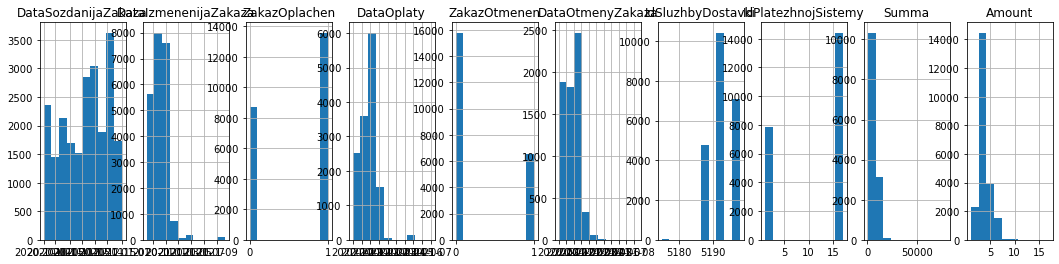

In [4]:
def load_crm_data():
    crm_data=pd.read_csv("crm_data.csv", sep=";", encoding="cp1251", decimal=",", parse_dates=['DataSozdanijaZakaza','DataIzmenenijaZakaza','DataOtmenyZakaza', 'DataOplaty'], na_values={'Campaign': '(not set)'}, dayfirst=True)
    crm_data['Summa']=pd.to_numeric(crm_data['Summa'].str.replace("?", "",regex=False).str.replace(",", ".",regex=True).str.replace(" ", "",regex=True))
    crm_data['IdPolzovatelja']=crm_data['IdPolzovatelja'].astype(str)
    crm_data=crm_data.rename(columns={"GoogleClientId": "gcid", "IdPolzovatelja": "pid"})
    crm_data['Campaign']=np.where(crm_data.Campaign.isnull(),'',crm_data.Campaign)
    return crm_data
#crm_data=load_crm_data()

truedescribe (load_crm_data(), 3)


### test_users
Список тестовых аккаунтов, все уникальные

In [5]:
def load_test_users():
    test_users=pd.read_csv("test_users.csv", sep=";", encoding="cp1251", decimal=",")
    test_users['IdPolzovatelja']=test_users['IdPolzovatelja'].astype(str)
    test_users=test_users.rename(columns={"IdPolzovatelja": "pid"})
    return test_users
#truedescribe (load_test_users(), 3)

### GA_data
Выгрузка действий пользователей на сайте. В 1.5 доказано, что "Финал" - это событие оплаты на сайте, "Оплата" - это событие создания заказа. Все utm-метки CRM записывает в момент создания заказа. Кроме того, Id объявлений facebook всегда передаются в параметре Content.

794 107 rows X  14 columns X 11 117 498 items X 10 390 133 nonnull items X 342 025  Kbytes
int64             7
object            6
datetime64[ns]    1


,DateTime,gcid,SessionCount,Sessions,Source,Medium,Campaign,Content,DeviceCategory,Добавить,В корзину,Завершение,Оплата,Финал
dtype,datetime64[ns],object,int64,int64,object,object,object,object,object,int64,int64,int64,int64,int64
nonnull%,100.00,100.00,100.00,100.00,100.00,100.00,100.00,8.40,100.00,100.00,100.00,100.00,100.00,100.00
count,794107,794107,794107.00,794107.00,794107,794107,794107,66742,794107,794107.00,794107.00,794107.00,794107.00,794107.00
unique,119549,415048,2228,2,309,13,2387,1300,3,2,2,2,2,2
mean,2020-11-20 14:18:43.500486400,NaN,12.16,0.79,NaN,NaN,NaN,NaN,NaN,0.15,0.05,0.08,0.03,0.01
median,2020-11-24 20:05:00,NaN,1.00,1.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00
top,NaN,746359960.1591701546,NaN,NaN,blogger,stories,,20029190527,mobile,NaN,NaN,NaN,NaN,NaN
freq,NaN,1644,NaN,NaN,362348,360393,161132,1484,711759,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,9658360.00,626973.00,NaN,NaN,NaN,NaN,NaN,117944.00,36214.00,61510.00,21093.00,11594.00
asc_0,2020-10-01 00:00:00,1000002598.1608113627,1,0,2gis.ru,(none),,14411569749,desktop,0,0,0,0,0


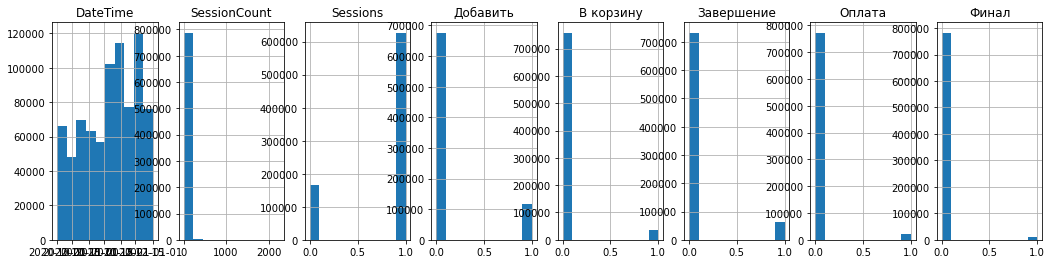

In [6]:
def load_ga_data():
    ga_data=pd.read_csv("ga_data.csv", sep=";", encoding="cp1251", decimal="," , parse_dates=['DateTime'], na_values={'Campaign': '(not set)'}, dtype={'Content': 'str'}, dayfirst=True) #dtype={'Цель GA — Добавить в корзину':bool, 'Цель GA — Кнопка перехода в корзину после кнопки Заказать':bool, 'Цель GA — Кнопка завершения оформления заказа в корзине':bool, 'Цель GA — Успешная оплата заказа':bool, 'Цель GA — Финал заказ подтвержден':bool}
    ga_data=ga_data.rename(columns={"ClientId": "gcid", 'Цель GA — Добавить в корзину':'Добавить', 'Цель GA — Кнопка перехода в корзину после кнопки Заказать':'В корзину', 'Цель GA — Кнопка завершения оформления заказа в корзине':'Завершение', 'Цель GA — Успешная оплата заказа':'Оплата', 'Цель GA — Финал заказ подтвержден':'Финал'})
    ga_data['Campaign']=np.where(ga_data.Campaign.isnull(),'',ga_data.Campaign)
    return ga_data
truedescribe(load_ga_data())

### GoogleAds_data
Выгрузка затрат на рекламные кампани гугла

In [7]:
def load_googleads_data():
    GoogleAds_data=pd.read_csv("GoogleAds_data.csv", sep=";", encoding="cp1251", decimal=",", parse_dates=['Date'], na_values={'CampaignName': '(not set)'}, dayfirst=True)
    GoogleAds_data=GoogleAds_data.rename(columns={"CampaignName": "Campaign"})
    GoogleAds_data['Campaign']=np.where(GoogleAds_data.Campaign.isnull(),'',GoogleAds_data.Campaign)
    return GoogleAds_data
#truedescribe(load_googleads_data())

### direct_data
Выгрузка затрат на рекламные кампани яндекса

In [8]:
def load_direct_data():
    direct_data=pd.read_csv("direct_data.csv", sep=";", encoding="cp1251", decimal=",", parse_dates=['Date'], na_values={'CampaignName': '(not set)'}, dayfirst=True)
    direct_data=direct_data.rename(columns={"CampaignName": "Campaign"})
    direct_data['Campaign']=np.where(direct_data.Campaign.isnull(),'',direct_data.Campaign)
    return direct_data
#truedescribe(load_direct_data())

### facebook_data
Выгрузка затрат на рекламные кампани фейсбука

2 882 rows X  12 columns X 34 584 items X 34 046 nonnull items X 2 620,56  Kbytes
object            7
float64           3
int64             1
datetime64[ns]    1


,Date,CampaignId,Campaign,AdSetId,AdsetName,AdId,AdName,DeviceTypeId,Clicks,Shows,Budget,JActions
dtype,datetime64[ns],object,object,object,object,object,object,int64,float64,float64,float64,object
nonnull%,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,81.33
count,2882,2882,2882,2882,2882,2882,2882,2882.00,2882.00,2882.00,2882.00,2344
unique,44,148,121,212,67,686,36,4,193,1219,2075,1451
mean,2020-11-13 12:15:29.354615040,NaN,NaN,NaN,NaN,NaN,NaN,2.34,16.82,2046.47,711.45,NaN
median,2020-12-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2.00,1.00,78.00,28.68,NaN
top,NaN,23846929419330628,CampaignName_113,23845632095110291,AdsetName_42,23846768174300628,AdName_21,NaN,NaN,NaN,NaN,"[\n {\n ""action_type"": ""video_view"",\n ..."
freq,NaN,324,324,62,299,32,326,NaN,NaN,NaN,NaN,234
sum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6752.00,48473.00,5897922.00,2050403.21,NaN
asc_0,2020-10-01 00:00:00,23845631149110291,CampaignName_1,23845631148900291,AdsetName_1,23845631149030291,AdName_1,0,0.00,1.00,0.00,"[\n {\n ""action_type"": ""comment"",\n ""va..."


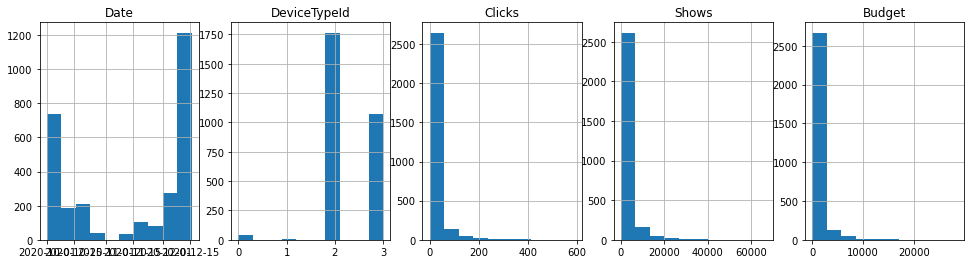

In [9]:
def load_facebook_data():
    facebook_data=pd.read_csv("facebook_data.csv", sep=";", encoding="cp1251", dtype={'CampaignId': 'str', 'AdSetId': 'str', 'AdId': 'str'}, decimal=",", na_values={'CampaignName': '(not set)'}, parse_dates=['Date'], dayfirst=True)
    facebook_data=facebook_data.rename(columns={"CampaignName": "Campaign"})
    facebook_data['Campaign']=np.where(facebook_data.Campaign.isnull(),'',facebook_data.Campaign)
    
    return facebook_data
truedescribe(load_facebook_data())

## create_ &nbsp;&nbsp;&nbsp; | &nbsp;&nbsp;&nbsp; Создание вспомогательных таблиц

### TrackTable
Создаёт таблицу отслеживания пользовательских устройств по аккаунтам (группирует пользовательские устройства). Одно или несколько устройств, использующих только один аккаунт получают в качестве id отслеживания (tid - track id) номер аккаунта. Устройства, использующие несколько аккаунтов, получают в качестве id отслеживания (tid) номер устройства (gcid).

Получает на вход dataset (crm_data) содержайщий соответствия устройств пользователей (gcid) и пользователей (pid), у которых они были замечены, а также перечень тестовых пользователей (test_users) и переченьдополнительных gcid (ga_data) без аккаунтов.

Возвращает соответствие уникальных устройств пользователей (gcid) и id отслеживания (tid - track id ) с пометкой устройств, которые встречались только в тестовых аккаунтах (IsTestGCID).

Опция gamerge=True дополняет соответствия устройствами, которые совершили оплату в похожее на зафиксированное по заказу время и не подходящее под другие заказы.

In [10]:
def create_tracktable (crm_data, test_users, ga_data, gamerge=True):
    ctable=crm_data.copy()
    test_users=test_users.copy()
    addg=ga_data[['gcid']].drop_duplicates().copy()
    ctable['gcid']=np.where(ctable.gcid.isnull(),ctable.pid,ctable.gcid)
# удаляем дубликаты устройств и пользователей
    ctable=ctable[['gcid', 'pid']].drop_duplicates().reset_index(drop=True)
# помечаем мультипользовательские устройства - которые заходят под разными аккаунтами
    ctable['multiacc']=ctable.duplicated(subset=['gcid'],keep=False)
# указываем в качестве track id (tid) каждому устройству номер пользователя, мультипользовательским устройствам в качестве 
# track id (tid) указываем номер устройства (gcid) для индвивидуального отслеживания
    ctable['tid']=np.where(ctable.multiacc==True,ctable.gcid,ctable.pid)
# оставляем только уникальные записи (равно уникальные устройства)
    ctable=ctable[['gcid', 'tid']].drop_duplicates()
    addg=addg[['gcid']].drop_duplicates()
# добавлем устройства без аккаунтов, их отслеживаем по номерам устройств
    ctable=pd.merge(ctable,addg,how='outer',left_on='gcid',right_on='gcid')
    ctable['tid']=np.where(ctable.tid.isnull(),ctable.gcid,ctable.tid)
 # устройства, которые отслеживаются по тестовому аккаунту помечаем как тестовые
    ctable=pd.merge(ctable, test_users, left_on='tid', right_on='pid', how='left', indicator='IsTestGCID').drop(columns='pid')
    ctable['IsTestGCID']=ctable['IsTestGCID'].map({'both': True, 'left_only': False, 'right_only': False}).astype('bool')
    ctable=ctable[['gcid', 'tid', 'IsTestGCID']]

# опция дополнения соответствиями устройств, которые совершили оплату в похожее на зафиксированное по заказу (и не подходящее под другие заказы) время .
    if (gamerge==True):
        #отбираем оплаты на сайте (другие не отразятся в гугл-аналитике)
        crm_pays=crm_data[crm_data['IdPlatezhnojSistemy']==17].dropna(subset=['DataOplaty'])
        #помечаем устройства из таблицы заказов уже найденными track id
        crm_pays['gcid1']=np.where(crm_pays.gcid.isnull(),crm_pays.pid,crm_pays.gcid)
        crm_pays=pd.merge(crm_pays,ctable, left_on='gcid1', right_on='gcid', how='left', suffixes=('', '_y')).drop(columns=['IsTestGCID', 'gcid1','gcid_y'])
        crm_pays=crm_pays[['DataOplaty', 'pid', 'gcid', 'tid']].sort_values(by=['DataOplaty'])
        
        #отбираем из гугл-аналитики события оплаты
        ga_pays=ga_data[(ga_data['Финал']==1)].copy()
        ga_pays=ga_pays[["DateTime","gcid"]]
        #помечаем устройства из гугланалитики уже найденными track id
        ga_pays=pd.merge(ga_pays,ctable, left_on='gcid', right_on='gcid', how='left')
        ga_pays=ga_pays[["DateTime","tid","gcid"]].sort_values(by=['DateTime'])


        #Выборка совпадений уже известных пользователей по tid

        tol = pd.Timedelta('3 minutes') #3 minutes
        t=pd.merge_asof(left=crm_pays, right=ga_pays, left_on='DataOplaty', right_on='DateTime', suffixes=('_x', ''), left_by='tid', right_by='tid', direction='nearest', tolerance=tol)
        t=t[t['DateTime'].notnull()]
        
        #Исключение совпадений уже известных пользователей из выборок
        ga_pays_unfined=pd.concat([ga_pays,t[['DateTime','tid']]]).drop_duplicates(subset=['DateTime','tid'],keep=False).sort_values(by=['DateTime'])
        crm_pays_unfined=pd.concat([crm_pays,t[['DataOplaty','tid']]]).drop_duplicates(subset=['DataOplaty','tid'],keep=False).sort_values(by=['DataOplaty'])


        #Выборка совпадений любых оплат, независимо от пользователя (неизвестных пользоателей, без параметров left_by='tid', right_by='tid')

        t=pd.merge_asof(left=crm_pays_unfined, right=ga_pays_unfined, left_on='DataOplaty', right_on='DateTime', suffixes=('_x', ''), direction='nearest', tolerance=tol)
        t=t[t['DateTime'].notnull()]
        
        #полученными соответствиями дополням перечень таблицы заказов и рекурсивно направляем для упорядочивания в эту же процедуру уже без поиска в гугл-аналитике 
        return create_tracktable(pd.concat([crm_data[['pid','gcid']],t[['pid','gcid']]]), test_users, ga_data, False)

    
    del test_users
    del addg
    return ctable

# crm_data=load_crm_data()
# test_users=load_test_users()
# ga_data=load_ga_data()

# truedescribe(create_tracktable(crm_data, test_users,ga_data))

## Дополнение данных новыми параметрами
### crm_data

In [11]:
def add_crm_data (crm_data, test_users, tracktable):
#инициализация
    test_users=test_users.copy()
    tracktable=tracktable.copy()
    crm_data=crm_data.drop(columns=['idStatusZakaza', 'IsTestOrder','Success', 'tid','OrderNumber'],errors='ignore')
# оцифровка статусов заказов (просто для удобства, нигде не используется)
    crm_data['idStatusZakaza'] = crm_data['StatusZakaza']
    crm_data.loc[crm_data['StatusZakaza'] == 'Заказ оформлен' , 'idStatusZakaza'] = 1
    crm_data.loc[crm_data['StatusZakaza'] == 'Выполнен' , 'idStatusZakaza'] = 2
    crm_data.loc[crm_data['StatusZakaza'] == 'Возврат заказа: ожидает отправки' , 'idStatusZakaza'] = 3
    crm_data.loc[crm_data['StatusZakaza'] == 'Проблемы с заказом' , 'idStatusZakaza'] = 4
    crm_data.loc[crm_data['StatusZakaza'] == 'Отказ от службы доставки' , 'idStatusZakaza'] = 5
    crm_data.loc[crm_data['StatusZakaza'] == 'Подтвержден' , 'idStatusZakaza'] = 6
    crm_data.loc[crm_data['StatusZakaza'] == 'Проверен' , 'idStatusZakaza'] = 7
    crm_data.loc[crm_data['StatusZakaza'] == 'Сборка: ожидание товара' , 'idStatusZakaza'] = 8
    crm_data.loc[crm_data['StatusZakaza'] == 'Подтверждение оплаты' , 'idStatusZakaza'] = 9
    crm_data.loc[crm_data['StatusZakaza'] == 'Промежуточный' , 'idStatusZakaza'] = 10
    crm_data.loc[crm_data['StatusZakaza'] == 'Возврат оплаты' , 'idStatusZakaza'] = 11
    crm_data['idStatusZakaza']=crm_data['idStatusZakaza'].astype('int64')

#Индикатор тестовых заказов - если аккаунт тестовый, то и заказ тестовый
    crm_data=pd.merge(crm_data, test_users, left_on='pid', right_on='pid', how='left', indicator='IsTestOrder')
    crm_data['IsTestOrder']=crm_data['IsTestOrder'].map({'both': True, 'left_only': False}).astype('bool')

#Индикатор успешного заказа - по которому есть оплата, но заказ не тестовый
    crm_data['Success']=np.logical_and(crm_data['ZakazOplachen'],np.logical_not(crm_data['IsTestOrder']))

#Индикатор успешного заказа - по которому есть оплата, но заказ не тестовый
    crm_data['gcid1']=np.where(crm_data.gcid.isnull(),crm_data.pid,crm_data.gcid)
    crm_data=pd.merge(crm_data,tracktable, left_on='gcid1', right_on='gcid', how='left', suffixes=('', '_y')).drop(columns=['IsTestGCID', 'gcid1','gcid_y'])

#Индекс - уникальный номер заказа
    crm_data['OrderNumber'] = np.arange(crm_data.shape[0])
    del test_users
    del tracktable
    return crm_data


# crm_data=load_crm_data()
# test_users=load_test_users()
# tracktable=create_tracktable(crm_data, test_users,load_ga_data())
# truedescribe(add_crm_data(crm_data,test_users,tracktable)[['idStatusZakaza', 'IsTestOrder', 'Success', 'tid', 'OrderNumber']],3)


### GA_data

In [12]:
def add_ga_data (ga_data, tracktable, facebook_data, googleads_data, direct_data):
#инициализация
    ga_data=ga_data.drop(columns=['IsTestGCID', 'tid','ActionNumber', 'advert', 'payedcomp', 'fbcindex'],errors='ignore')

#Отмечаем тестовых пользователей
    ga_data=pd.merge(ga_data,tracktable, left_on='gcid', right_on='gcid', how='left')
    ga_data['IsTestGCID']=ga_data['IsTestGCID'].fillna(False).astype('bool')

# создаём индекс всех событий
    ga_data['ActionNumber'] = np.arange(ga_data.shape[0])

# помечал все затратные кампании для удобства в аналитике. Не помогло
    fbc=facebook_data[['CampaignId']].rename(columns={"CampaignId": "Campaign"}).drop_duplicates().reset_index(drop=True)

    gadsc=googleads_data[['Campaign']].drop_duplicates().reset_index(drop=True)
    ddc=direct_data[['Campaign']].drop_duplicates().reset_index(drop=True)
    payedcomp=pd.concat([fbc,gadsc,ddc])

# размечаем источники
    fblist=['facebook.com', 'fb', 'ig', 'Instagram', 'instagram', 'instagram.com', 'instagram_facebook', 'l.facebook.com', 'l.instagram.com', 'm.facebook.com']
    yalist=['mail.yandex.ru', 'yandex', 'yandex.by', 'yandex.com.tr', 'yandex.fr', 'yandex.kz', 'yandex.ru', 'yandex.ua', 'yandex.uz', 'zen.yandex.com', 'zen.yandex.ru']
    glist=['google','googleapis.com']

    ga_data['ya']=ga_data.Source.isin(yalist)
    ga_data['fb']=ga_data.Source.isin(fblist) | ga_data.Medium.isin(fblist)
    ga_data['goo']=ga_data.Source.isin(glist)

    ga_data['advert']=np.nan

    ga_data['advert']=np.where(ga_data.ya,'yandex',ga_data.advert)
    ga_data['advert']=np.where(ga_data.goo,'google',ga_data.advert)
    ga_data['advert']=np.where(ga_data.fb,'facebook',ga_data.advert) 

    ga_data['payedcomp']=ga_data.Campaign.isin(payedcomp['Campaign'])

# индекс для привязки объявлений к событиям в гугл-аналитике. Является составным ключом из даты и названия объявлен9ия
    ga_data['fbcindex']=np.where(ga_data.fb & ga_data.payedcomp,ga_data.DateTime.dt.date.astype(str)+'|'+ga_data.Content.astype(str), np.nan)

    ga_data=ga_data.drop(columns=['ya','fb','goo'])
    return ga_data


# crm_data=load_crm_data()
# test_users=load_test_users()
# ga_data=load_ga_data()
# tracktable=create_tracktable(crm_data, test_users, ga_data)

# truedescribe(add_ga_data(ga_data,tracktable,load_facebook_data(),load_googleads_data(), load_direct_data())[['tid', 'IsTestGCID', 'ActionNumber', 'advert', 'payedcomp', 'fbcindex']],3)


### facebook_data

2 882 rows X  33 columns X 95 106 items X 95 106 nonnull items X 2 054,75  Kbytes
float64           24
object             7
int64              1
datetime64[ns]     1


,Date,CampaignId,Campaign,AdSetId,AdsetName,AdId,AdName,DeviceTypeId,Clicks,Shows,Budget,fbcindex,add_to_cart,comment,initiate_checkout,landing_page_view,link_click,offsite_conversion.custom.382746462713600,offsite_conversion.custom.688225158437026,offsite_conversion.custom.703103973626824,offsite_conversion.fb_pixel_add_to_cart,offsite_conversion.fb_pixel_initiate_checkout,offsite_conversion.fb_pixel_purchase,omni_add_to_cart,omni_initiated_checkout,omni_purchase,onsite_conversion.post_save,page_engagement,post,post_engagement,post_reaction,purchase,video_view
dtype,datetime64[ns],object,object,object,object,object,object,int64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nonnull%,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
count,2882,2882,2882,2882,2882,2882,2882,2882.00,2882.00,2882.00,2882.00,2882,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00,2882.00
unique,44,148,121,212,67,686,36,4,193,1219,2075,885,66,4,33,177,193,26,13,214,66,33,19,66,33,19,22,781,14,781,26,19,796
mean,2020-11-13 12:15:29.354615040,NaN,NaN,NaN,NaN,NaN,NaN,2.34,16.82,2046.47,711.45,NaN,2.84,0.02,1.29,14.43,16.04,0.53,0.13,18.88,2.84,1.29,0.48,2.84,1.29,0.48,0.22,485.65,0.40,485.65,0.36,0.48,468.61
median,2020-12-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2.00,1.00,78.00,28.68,NaN,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.50,0.00,11.50,0.00,0.00,10.00
top,NaN,23846929419330628,CampaignName_113,23845632095110291,AdsetName_42,23846768174300628,AdName_21,NaN,NaN,NaN,NaN,2020-10-20|23845794362210291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,324,324,62,299,32,326,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6752.00,48473.00,5897922.00,2050403.21,NaN,8183.00,44.00,3712.00,41581.00,46225.00,1522.00,362.00,54414.00,8183.00,3712.00,1375.00,8183.00,3712.00,1375.00,622.00,1399634.00,1158.00,1399634.00,1044.00,1375.00,1350541.00
asc_0,2020-10-01 00:00:00,23845631149110291,CampaignName_1,23845631148900291,AdsetName_1,23845631149030291,AdName_1,0,0.00,1.00,0.00,2020-10-01|23845631149030291,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


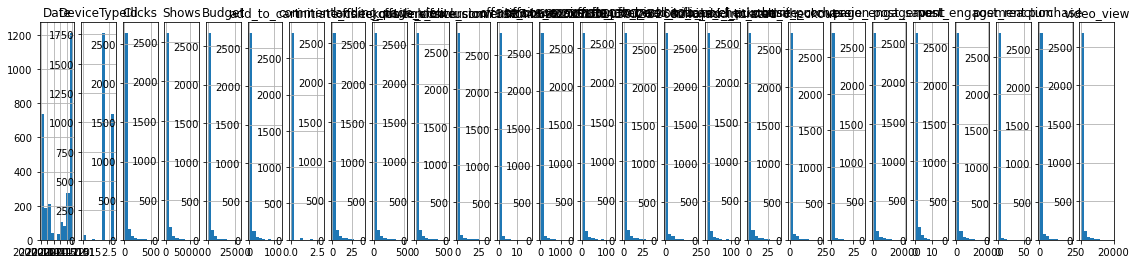

In [13]:
def add_facebook_data (facebook_data):

#инициация
    facebook_data=facebook_data.drop(columns=['fbcindex', 'add_to_cart' , 'comment' , 'initiate_checkout' , 'landing_page_view' , 'link_click' , 'offsite_conversion.custom.382746462713600' , 'offsite_conversion.custom.688225158437026' , 'offsite_conversion.custom.703103973626824' , 'offsite_conversion.fb_pixel_add_to_cart' , 'offsite_conversion.fb_pixel_initiate_checkout' , 'offsite_conversion.fb_pixel_purchase' , 'omni_add_to_cart' , 'omni_initiated_checkout' , 'omni_purchase' , 'onsite_conversion.post_save' , 'page_engagement' , 'post' , 'post_engagement' , 'post_reaction' , 'purchase' , 'video_view'],errors='ignore')

#разворачиваем из колонки Jactions. Вообще никак не помогло и не используется. События фейсбука и гугла не мэтчатся и, похоже, это чёрная кошка которой нет в комнате.
#не беспокойся: я сам не знаю как это работает
    ja=pd.concat(facebook_data[facebook_data.JActions.notna()]['JActions'].apply(pd.io.json.read_json).to_list(), keys=facebook_data.index)
    ja=ja.reset_index().drop(columns='level_1').pivot('level_0', 'action_type')['value'].rename_axis(None, axis='index').rename_axis(None, axis='columns')
    facebook_data=facebook_data.drop(columns=['JActions'])

    # индекс для привязки объявлений к событиям в гугл-аналитике. Является составным ключом из даты и названия объявлен9ия

    facebook_data['fbcindex']=facebook_data.Date.dt.date.astype(str)+'|'+facebook_data.AdId
    
    return pd.concat([facebook_data,ja], axis=1).fillna(0)

truedescribe(add_facebook_data(load_facebook_data()))#[['fbcindex', 'add_to_cart' , 'comment' , 'initiate_checkout' , 'landing_page_view' , 'link_click' , 'offsite_conversion.custom.382746462713600' , 'offsite_conversion.custom.688225158437026' , 'offsite_conversion.custom.703103973626824' , 'offsite_conversion.fb_pixel_add_to_cart' , 'offsite_conversion.fb_pixel_initiate_checkout' , 'offsite_conversion.fb_pixel_purchase' , 'omni_add_to_cart' , 'omni_initiated_checkout' , 'omni_purchase' , 'onsite_conversion.post_save' , 'page_engagement' , 'post' , 'post_engagement' , 'post_reaction' , 'purchase' , 'video_view']])

# Описание связей данных CRM и GA

##  Связи событий
Раздел доказательства, что Финал в GA это оплата заказа в CRM (для оплат на сайте), а оплата - это создание заказа. Раздел не нужен для обработки данных, его можно пропустить.

Финал  Добавить  В корзину  \
event                IdPlatezhnojSistemy Success                                
DataIzmenenijaZakaza 1                   False      0.00     25.00      23.00   
                                         True       0.00      2.00       1.00   
                     17                  False      3.00      8.00      22.00   
                                         True       4.00     27.00       3.00   
DataOplaty           1                   False      0.00      0.00       0.00   
                                         True       0.00      2.00       0.00   
                     17                  False    135.00      2.00       1.00   
                                         True    7772.00     27.00      13.00   
DataOtmenyZakaza     1                   False      0.00     22.00      24.00   
                                         True       0.00      0.00       0.00   
                     17                  False      3.00      9.00      21.00   
                                         True       0.00      0.00       0.00   
DataSozdanijaZakaza  1                   False      0.00     27.00      13.00   
                                         True       0.00     12.00       6.00   
                     17                  False     37.00     21.00      39.00   
                                         True    1242.00      8.00      32.00   

                                                  Завершение  Оплата  
event                IdPlatezhnojSistemy Success                      
DataIzmenenijaZakaza 1                   False         53.00   74.00  
                                         True           3.00  108.00  
                     17                  False         31.00   17.00  
                                         True           5.00    1.00  
DataOplaty           1                   False          0.00    0.00  
                                         True           2.00    1.00  
                     17                  False          1.00   25.00  
                                         True          18.00 1014.00  
DataOtmenyZakaza     1                   False         52.00   36.00  
                                         True           0.00    0.00  
                     17                  False         34.00   15.00  
                                         True           0.00    0.00  
DataSozdanijaZakaza  1                   False         32.00 3721.00  
                                         True           7.00 3686.00  
                     17                  False         77.00 3859.00  
                                         True          31.00 8397.00

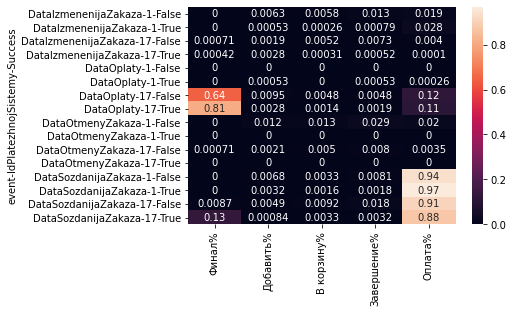

In [24]:
#подгрузка данных

crm_data=load_crm_data()
test_users=load_test_users()
ga_data=load_ga_data()
# direct_data=load_direct_data()
facebook_data=load_facebook_data()

tracktable=create_tracktable(crm_data, test_users, ga_data, False) #для демонстрации генерируется таблица отслеживания с выключенным метчингом оплат

ga_data=add_ga_data(ga_data,tracktable,facebook_data,googleads_data, direct_data)
facebook_data=add_facebook_data(facebook_data)
crm_data=add_crm_data(crm_data,test_users,tracktable)

#Создаёт таблицу событий из таблицы заказов выстраивая все временные колонки в одну с пометкой события.
events=crm_data.drop(columns=['StatusZakaza', 'Source', 'Medium', 'Campaign', 'Summa', 'Amount'])

events=pd.concat([events.drop(columns=['DataIzmenenijaZakaza', 'DataOplaty', 'DataOtmenyZakaza']).rename(columns={"DataSozdanijaZakaza": "EventDT"}),
                events.drop(columns=['DataSozdanijaZakaza', 'DataIzmenenijaZakaza', 'DataOtmenyZakaza']).rename(columns={"DataOplaty": "EventDT"}),
                events.drop(columns=['DataSozdanijaZakaza', 'DataOplaty', 'DataOtmenyZakaza']).rename(columns={"DataIzmenenijaZakaza": "EventDT"}),
                events.drop(columns=['DataSozdanijaZakaza', 'DataIzmenenijaZakaza', 'DataOplaty']).rename(columns={"DataOtmenyZakaza": "EventDT"})],
                keys=['DataSozdanijaZakaza' ,'DataOplaty' ,'DataIzmenenijaZakaza' ,'DataOtmenyZakaza']).reset_index().drop(columns='level_1').rename(columns={"level_0": "event"}).dropna(subset=['EventDT'])
    
#отбираем все события в GA  
ga_data1=ga_data[(ga_data['Финал']+ga_data['Добавить']+ga_data['В корзину']+ga_data['Завершение']+ga_data['Оплата']>0)]

#Группируем по времени и дате
ga_data1=ga_data1[["DateTime", "Финал", "Добавить", "В корзину", "Завершение","Оплата","tid"]].sort_values(by=['DateTime'])
ga_data1=ga_data1.groupby(by=['DateTime', 'tid']).agg({"Финал":np.sum, "Добавить":np.sum, "В корзину":np.sum, "Завершение":np.sum,"Оплата":np.sum}).reset_index()

# делаем слияние с допуском расхождения времени в 3 минуты и обязательным совпадением номера отслеживания
events=events.sort_values(by=['EventDT'])
ga_data1=ga_data1.sort_values(by=['DateTime'])
tol = pd.Timedelta('3 minutes') #25 minutes
t=pd.DataFrame()
t=pd.merge_asof(left=events, right=ga_data1, left_on='EventDT', right_on='DateTime', left_by='tid', right_by='tid', direction='nearest', tolerance=tol)

#Отбираем и выстраиваем метрики совпадения событий
t['gcidna']=t.gcid.isna()
t=t[(t['gcidna']==False) & (t['IsTestOrder']==False)]
t=t[['event', 'EventDT', 'DateTime', 'Финал', 'Добавить', 'В корзину', 'Завершение', 'Оплата','IdPlatezhnojSistemy', 'Success', 'gcidna', 'ZakazOtmenen', 'IdSluzhbyDostavki']].groupby(by=['event', 'IdPlatezhnojSistemy','Success']).agg({"EventDT":'count', "Финал":np.sum, "Добавить":np.sum, "В корзину":np.sum, "Завершение":np.sum,"Оплата":np.sum})
t['Финал%']=t['Финал']/t['EventDT']
t['Добавить%']=t['Добавить']/t['EventDT']
t['В корзину%']=t['В корзину']/t['EventDT']
t['Завершение%']=t['Завершение']/t['EventDT']
t['Оплата%']=t['Оплата']/t['EventDT']
sns.heatmap(t[['Финал%','Добавить%','В корзину%','Завершение%','Оплата%']], annot=True)
t[['Финал','Добавить','В корзину','Завершение','Оплата']]

# итого - совпадение оплат на сайте и созданий заказов на уровне выше 80%

## связи оплат и заказов
Раздел показвающий, что методика опознания пользователей по оплатам позволяет повысить узнаваемость оплат пользователями на 6 процентных пунктов 

EventDT  DateTime  \
gcidna event               IdPlatezhnojSistemy Success                      
False  DataOplaty          17                  False        211       153   
                                               True        9577      8395   
       DataSozdanijaZakaza 1                   False       3985      3659   
                                               True        3808      3564   
                           17                  False       4631      3799   
                                               True        9577      8709   
True   DataOplaty          17                  False          6         0   
                                               True         152        20   
       DataSozdanijaZakaza 1                   False         36         0   
                                               True          42         0   
                           17                  False         60         0   
                                               True         152         0   

                                                        DateTime%  
gcidna event               IdPlatezhnojSistemy Success             
False  DataOplaty          17                  False         0.73  
                                               True          0.88  
       DataSozdanijaZakaza 1                   False         0.92  
                                               True          0.94  
                           17                  False         0.82  
                                               True          0.91  
True   DataOplaty          17                  False         0.00  
                                               True          0.13  
       DataSozdanijaZakaza 1                   False         0.00  
                                               True          0.00  
                           17                  False         0.00  
                                               True          0.00

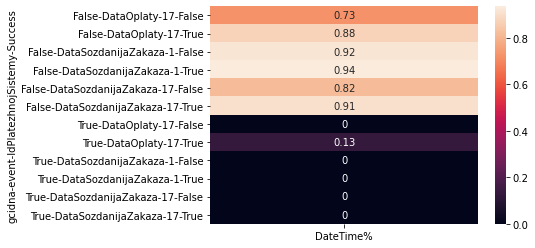

In [28]:
#подгружаем данные
crm_data=load_crm_data()
test_users=load_test_users()
ga_data=load_ga_data()
facebook_data=load_facebook_data()
direct_data=load_direct_data()

tracktable=create_tracktable(crm_data, test_users, ga_data, True)

ga_data=add_ga_data(ga_data,tracktable,facebook_data,googleads_data, direct_data)
facebook_data=add_facebook_data(facebook_data)
crm_data=add_crm_data(crm_data,test_users,tracktable)

# Отдельно совмещаем оплаты с допуском в три минуты
tol = pd.Timedelta('3 minutes') 

# отбираем события оплаты в GA
ga_events=ga_data[(ga_data['Финал']==1)].copy()
ga_events=ga_events[["DateTime","tid"]].sort_values(by=['DateTime'])

# отбираем события онлайн-оплаты в CRM
crm_events=crm_data[crm_data['IdPlatezhnojSistemy']==17].dropna(subset=['DataOplaty'])
crm_events=crm_events.sort_values(by=['DataOplaty'])

t=pd.merge_asof(left=crm_events, right=ga_events, left_on='DataOplaty', right_on='DateTime', suffixes=('', '_x'), left_by='tid', right_by='tid', direction='nearest', tolerance=tol)

# Отдельно совмещаем оплаты с допуском в 9 минут
tol = pd.Timedelta('9 minutes')
ga_events=ga_data[(ga_data['Оплата']==1)].copy() 
ga_events=ga_events[["DateTime","tid", 'gcid', 'Campaign']].sort_values(by=['DateTime'])
crm_events=crm_data
crm_events=crm_events.sort_values(by=['DataSozdanijaZakaza'])

# Формируем результаты в разрезе наличия идентификатора устройства, события и способа оплаты
t1=pd.merge_asof(left=crm_events, right=ga_events, left_on='DataSozdanijaZakaza', right_on='DateTime', suffixes=('', '_x'), left_by=['gcid', 'Campaign'] , right_by=['gcid', 'Campaign'], direction='nearest', tolerance=tol)
t=pd.concat([t1.rename(columns={"DataSozdanijaZakaza": "EventDT"}), t.rename(columns={"DataOplaty": "EventDT"})], keys=['DataSozdanijaZakaza', 'DataOplaty']).reset_index().rename(columns={"level_0": "event"})
t['gcidna']=np.where(t.gcid.isna(),True,False)
t=t.groupby(by=['gcidna','event', 'IdPlatezhnojSistemy','Success']).agg({"EventDT":'count', "DateTime":'count'})
t['DateTime%']=t['DateTime']/t['EventDT']
sns.heatmap(t[['DateTime%']], annot=True)
t
# Найдено 88% оплат!

# Создание таблицы событий по заказам и выгрузка данных для PowerBI

In [20]:
#подгружаем данные
crm_data=load_crm_data()
test_users=load_test_users()
ga_data=load_ga_data()
direct_data=load_direct_data()
facebook_data=load_facebook_data()
googleads_data=load_googleads_data()

tracktable=create_tracktable(crm_data, test_users, ga_data, True)

ga_data=add_ga_data(ga_data,tracktable,facebook_data,googleads_data, direct_data)
facebook_data=add_facebook_data(facebook_data)
crm_data=add_crm_data(crm_data,test_users,tracktable)

#сразу сохраняем данные, которые больше не будут изменяться
direct_data.to_csv(path_or_buf="p_direct_data.csv", sep=';', decimal=',', index=False)
facebook_data.to_csv(path_or_buf="p_facebook_data.csv", sep=';', decimal=',', index=False)
googleads_data.to_csv(path_or_buf="p_googleads_data.csv", sep=';', decimal=',', index=False)

In [21]:
# подготовка к формированию таблицы событий по заказам, связываем заказы и финальные события по заказам

# для оплат на сайте финальное событие - оплата. Выделяем оплаты
ga_events=ga_data[(ga_data['Финал']==1)]
ga_events=ga_events[["DateTime","tid", "ActionNumber"]].sort_values(by=['DateTime'])

crm_data['FinalPay']=np.where(crm_data.DataOplaty.notnull(),crm_data.DataOplaty,np.datetime64('2000-01-01'))

crm_data['FinalOrder']=np.where(crm_data.DataSozdanijaZakaza.notnull(),crm_data.DataSozdanijaZakaza,np.datetime64('2000-01-01'))

crm_data=crm_data.sort_values(by=['FinalPay'])

# пристыковываем оплаты с допуском в три минуты с совпадением по номеру отслеживания
tol = pd.Timedelta('3 minutes')
crm_data=pd.merge_asof(left=crm_data, right=ga_events, left_on='FinalPay', right_on='DateTime', suffixes=('', '_FinalPay'), left_by='tid', right_by='tid', direction='nearest', tolerance=tol)

# для не найденных оплат увеличиваем окно до 20 минут и ищем совпадения по устройству и кампании
tol = pd.Timedelta('20 minutes')
ga_events=ga_data[(ga_data['Оплата']==1)]
ga_events=ga_events[["DateTime","tid", 'gcid', 'Campaign', "ActionNumber"]].sort_values(by=['DateTime'])
crm_data=crm_data.sort_values(by=['FinalOrder'])

crm_data=pd.merge_asof(left=crm_data, right=ga_events, left_on='FinalOrder', right_on='DateTime', suffixes=('', '_FinalOrder'), left_by=['gcid', 'Campaign'] , right_by=['gcid', 'Campaign'], direction='nearest', tolerance=tol)


# проставляем финальные события в зависимости от типа оплаты
crm_data['FinalAction']=np.where((~(crm_data.IdPlatezhnojSistemy==17) & (crm_data.Success==True)),crm_data.ActionNumber_FinalOrder,crm_data.ActionNumber)
crm_data['FinalAction']=np.where(((crm_data.IdPlatezhnojSistemy==17) & (crm_data.Success==True) & crm_data.FinalAction.isna()),crm_data.ActionNumber_FinalOrder,crm_data.FinalAction)
crm_data['FinalActionDT']=np.where((~(crm_data.IdPlatezhnojSistemy==17) & (crm_data.Success==True)),crm_data.DateTime_FinalOrder,crm_data.DateTime)
crm_data['FinalActionDT']=np.where(((crm_data.IdPlatezhnojSistemy==17) & (crm_data.Success==True) & crm_data.FinalActionDT.isna()),crm_data.DateTime_FinalOrder,crm_data.FinalActionDT)
crm_data=crm_data.drop(columns=['DateTime', 'FinalPay', 'ActionNumber','DateTime_FinalOrder', 'tid_FinalOrder', 'ActionNumber_FinalOrder'],errors='ignore')
crm_data=pd.merge_asof(left=crm_data, right=ga_events, left_on='FinalOrder', right_on='DateTime', suffixes=('', '_FinalOrder'), left_by=['gcid'] , right_by=['gcid'], direction='nearest', tolerance=tol)
crm_data['FinalAction']=np.where(crm_data.FinalAction.isna(),crm_data.ActionNumber,crm_data.FinalAction)
crm_data['FinalActionDT']=np.where(crm_data.FinalActionDT.isna(),crm_data.DateTime,crm_data.FinalActionDT)
crm_data=crm_data.drop(columns=['DateTime', 'FinalOrder', 'Campaign_FinalOrder', 'FinalPay', 'ActionNumber','DateTime_FinalOrder', 'tid_FinalOrder', 'ActionNumber_FinalOrder'],errors='ignore')

# около 10% финальных событий не найдено (они могли не отразиться по разным причинам), их генерируем из данных в заказе.
mactions=crm_data[crm_data['FinalAction'].isnull()]
mactions=mactions[['DataSozdanijaZakaza','Source', 'Medium','Campaign', 'gcid', 'tid', 'IsTestOrder', 'OrderNumber']].rename(columns={"DataSozdanijaZakaza": "DateTime", "IsTestOrder": "IsTestGCID"})
mactions['gcid']=np.where(mactions.gcid.isnull(),mactions.tid,mactions.gcid)
mactions['Оплата']=1
mactions['SessionCount']=1
mactions['ActionNumber']=np.arange(len(ga_data),len(ga_data)+len(mactions))

# добавляем в заказы номера сгенерированных событий и выгружаем таблицу
crm_data=pd.merge(crm_data,mactions[['OrderNumber','ActionNumber']], left_on='OrderNumber', right_on='OrderNumber', how='left')
crm_data['FinalAction']=np.where(crm_data.FinalAction.isna(),crm_data.ActionNumber,crm_data.FinalAction)
crm_data['FinalActionDT']=np.where(crm_data.FinalActionDT.isna(),crm_data.DataSozdanijaZakaza,crm_data.FinalActionDT)
crm_data=crm_data.drop(columns=['ActionNumber'],errors='ignore')

crm_data.to_csv(path_or_buf="p_crm_data.csv", sep=';', decimal=',', index=False)

In [22]:
# создаём таблицу событий по заказам.события, совершённые пользователем дублируются столько раз, сколько он в последующем делал заказ, каждый дубликат получит номер заказа

k=crm_data[['tid', 'OrderNumber', 'FinalAction', 'FinalActionDT', 'Success']]
orderactions=pd.merge(pd.concat([ga_data,mactions.drop(columns=['OrderNumber'],errors='ignore')]), k, left_on='tid', right_on='tid', how='left')

#удаляем дубликаты событий после заказа
orderactions['del']=np.where(orderactions.DateTime>orderactions.FinalActionDT,True,False)

orderactions=orderactions[orderactions['del']==False]

#добавляем имена объявлений вместо кампаний
fbcindex=facebook_data[['fbcindex', 'AdName']] #[facebook_data['Clicks']>0]
fbcindex.drop_duplicates(inplace=True)

orderactions=pd.merge(orderactions, fbcindex, left_on='fbcindex', right_on='fbcindex', how='left')
orderactions['Campaign']=np.where(orderactions.AdName.notna(),orderactions.AdName,orderactions.Campaign)
orderactions.drop(columns=['AdName'],errors='ignore', inplace=True)

#добавляем номера событий по заказам
orderactions['OActionNumber'] = np.arange(orderactions.shape[0])

# помечаем первые и последние клики. _empty помечают первыми и последними также клики без кампаний
orderactions['CA']=np.where(~(orderactions.Campaign==''),True,False)
orderactions['FA']=np.where(orderactions.ActionNumber==orderactions.FinalAction,True,False)
orderactions['OR']=np.where(orderactions['Оплата']==1,True,False)
orderactions['PA']=np.where(orderactions['Финал']==1,True,False)

lastclicks=orderactions.sort_values(by=['CA','DateTime', 'FA', 'OR', 'PA'], ascending=False).groupby(by='OrderNumber').agg(lambda x: x.iloc[0])[['OActionNumber']]
lastclicks_empty=orderactions.sort_values(by=['DateTime', 'FA', 'CA', 'OR', 'PA'], ascending=False).groupby(by='OrderNumber').agg(lambda x: x.iloc[0])[['OActionNumber']]
firstclicks=orderactions.sort_values(by=['CA','DateTime', 'Sessions'], ascending=[False, True, False]).groupby(by='OrderNumber').agg(lambda x: x.iloc[0])[['OActionNumber']]
firstclicks_empty=orderactions.sort_values(by=['DateTime', 'CA', 'Sessions'], ascending=[True, False, False]).groupby(by='OrderNumber').agg(lambda x: x.iloc[0])[['OActionNumber']]

orderactions.drop(columns=['CA', 'FA','OR', 'PA'],errors='ignore', inplace=True)

orderactions=pd.merge(orderactions, firstclicks, left_on='OActionNumber', right_on='OActionNumber', how='left', indicator='firstclick')
orderactions['firstclick']=orderactions['firstclick'].map({'both': True, 'left_only': False}).astype('bool')

orderactions=pd.merge(orderactions, lastclicks, left_on='OActionNumber', right_on='OActionNumber', how='left', indicator='lastclick')
orderactions['lastclick']=orderactions['lastclick'].map({'both': True, 'left_only': False}).astype('bool')


<ipython-input-22-62c4e6a8fbaa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fbcindex.drop_duplicates(inplace=True)


In [23]:
orderactions=pd.merge(orderactions, firstclicks_empty, left_on='OActionNumber', right_on='OActionNumber', how='left', indicator='firstclick_empty')
orderactions['firstclick_empty']=orderactions['firstclick_empty'].map({'both': True, 'left_only': False}).astype('bool')

orderactions=pd.merge(orderactions, lastclicks_empty, left_on='OActionNumber', right_on='OActionNumber', how='left', indicator='lastclick_empty')
orderactions['lastclick_empty']=orderactions['lastclick_empty'].map({'both': True, 'left_only': False}).astype('bool')

orderactions=orderactions[orderactions.OrderNumber.notnull()]

# Выгружаем данные 
orderactions.to_csv(path_or_buf="p_orderactions.csv", sep=';', decimal=',', index=False)


Готово. Дальше всё подгружается в Power BI